# Loss function Rodrigues

$𝒟 = \{ \mathbf{x}_n, \mathbf{y}_n\}$ be a dataset of size $N$

$\mathbf{x}_n \in \mathbb{R}^D$

${\mathbf{y}}^r_n\in[0,1]^K$:   label provided for the r-th annotator in a set of R annotators

$𝒛_n$ Latent true class determined by a softmax output layer  of a DNN


$\mathbf{\sigma}\in \mathbb{R} ^Q$: DNN-based feature representation. correspond to the output of a softmax layer

$\hat{\mathbf{y}}^r_n = f_r(\sigma)\in[0,1]^{1 \times K}$

$\hat{\mathbf{y}}_n=[\hat{\mathbf{y}}^1_n,\hat{\mathbf{y}}^2_n,\dots,\hat{\mathbf{y}}^R_n]\in [0,1]^{1\times (R\times K)}$

Activation of the crowd layer for each anotator  $ \mathbf{a}^r = f_r(\sigma)$, where $f_r$ is an annotator-specific function, and the output of the crowd layer simply as the softmax of the
activations $o_c^r = e^{a_c^r}/\sum_{l=1}^{C}e^{a_l^r}$.


 $f_r(\sigma)= \mathbf{W}^r\mathbf{\sigma}$

 $\mathbf{W}^r$ is an annotator-specific matrix

 **Cost function**

 $E(\mathbf{o}^r, y^r)$
 between the expected output of the r-th annotator and its actual label $y^r$,

Then, 

if we make. $\lambda_n^r(\theta) = \mathbf{1}$ in PRI loss



$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$

 
we can obtain rodriguez


$$\min_\theta \sum_n\left(\sum_r (\mathbf{1})H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\mathbf{1}\right)\right)$$

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Crowdlayer class

In [2]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [3]:
import matplotlib.pyplot as plt
 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)
    
class MaskedMultiCrossEntropy(object):

	def loss(self, y_true, y_pred):
		vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
		mask = tf.equal(y_true[:,0,:], -1)
		zer = tf.zeros_like(vec)
		loss = tf.where(mask, x=zer, y=vec)
		return loss



In [4]:
def custom_CLR_loss(y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
    #tf.print(y_true)
    K=2
    Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth= K,axis=1) #samples, classes 1-K, annotators
    #tf.print(Y_true_1K)
    #print(Y_true_1K.shape)    
    vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
    tf.print(y_pred)
    #print(vec.shape)
    #mask = tf.equal(Y_true_1K[:,0,:], -1)
    #zer = tf.zeros_like(vec)
    #loss = tf.where(mask, x=zer, y=vec)
    #tf.print("loss", loss)
    return tf.math.reduce_sum(vec)

In [5]:
train_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')
Test_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_Te')


2023-02-14 11:39:26.821653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:39:26.897084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:39:26.897942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 11:39:26.899691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:

image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [7]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [8]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [9]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [10]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [11]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

2023-02-14 11:39:29.285810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


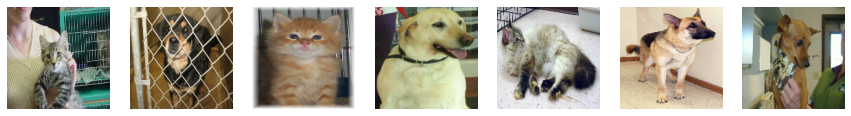

In [12]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label, t in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
   #ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1

In [13]:
# shuffle and create batches before training
batch_size = 128
train_batches = train_ds.shuffle(1024).batch(batch_size)
val_batches  = val_ds.shuffle(1024).batch(batch_size)
test_batches =  Test_data.shuffle(1024).batch(batch_size)

In [14]:
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization

# from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
# from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator

def build_base_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128, bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES,bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [15]:
N_CLASSES = 2
def one_hot(image, ytrue, label):
    one_hot_targets = tf.one_hot(tf.cast(label, tf.int32), N_CLASSES, axis = 1, dtype=tf.int32)
    return image, one_hot_targets


In [16]:

train_batches_MA = train_batches.map(one_hot)

In [17]:
val_batches_MA = val_batches.map(one_hot)

In [18]:

for i in train_batches_MA:
  print(i)
  break


(<tf.Tensor: shape=(128, 150, 150, 3), dtype=float32, numpy=
array([[[[2.32827887e-01, 2.80540317e-01, 3.43285412e-01],
         [1.96130723e-01, 2.98588246e-01, 3.06901962e-01],
         [1.76418319e-01, 3.01908523e-01, 2.96348602e-01],
         ...,
         [9.90771294e-01, 9.79834437e-01, 9.44339752e-01],
         [9.61934626e-01, 9.48705912e-01, 9.31032658e-01],
         [9.64662313e-01, 9.68583882e-01, 9.11695004e-01]],

        [[2.47241840e-01, 2.95607865e-01, 3.56392175e-01],
         [1.74980402e-01, 2.65176475e-01, 2.80862749e-01],
         [2.03241840e-01, 3.19163412e-01, 3.18640530e-01],
         ...,
         [1.00000000e+00, 9.94143844e-01, 9.94039237e-01],
         [1.00000000e+00, 9.84705925e-01, 9.94039237e-01],
         [9.93542433e-01, 9.90562022e-01, 9.71895337e-01]],

        [[2.07625270e-01, 2.63834417e-01, 3.14814806e-01],
         [1.87189549e-01, 2.73464054e-01, 2.95032680e-01],
         [1.86187357e-01, 2.90413946e-01, 2.93812633e-01],
         ...,
        

In [19]:
callback1 = tf.keras.callbacks.TerminateOnNaN()
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
#callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                         patience=15, verbose=0, mode="auto",
                                         baseline=None, restore_best_weights=True)

Epoch 1/50


2023-02-14 11:39:54.706822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 - 68s - loss: 0.7211 - val_loss: 0.6959
Epoch 2/50
110/110 - 10s - loss: 0.6990 - val_loss: 0.6939
Epoch 3/50
110/110 - 10s - loss: 0.6947 - val_loss: 0.6959
Epoch 4/50
110/110 - 11s - loss: 0.6921 - val_loss: 0.6935
Epoch 5/50
110/110 - 10s - loss: 0.6880 - val_loss: 0.6914
Epoch 6/50
110/110 - 10s - loss: 0.6820 - val_loss: 0.6877
Epoch 7/50
110/110 - 10s - loss: 0.6749 - val_loss: 0.6810
Epoch 8/50
110/110 - 10s - loss: 0.6618 - val_loss: 0.6790
Epoch 9/50
110/110 - 10s - loss: 0.6517 - val_loss: 0.6724
Epoch 10/50
110/110 - 9s - loss: 0.6411 - val_loss: 0.6617
Epoch 11/50
110/110 - 10s - loss: 0.6319 - val_loss: 0.6550
Epoch 12/50
110/110 - 10s - loss: 0.6213 - val_loss: 0.6591
Epoch 13/50
110/110 - 10s - loss: 0.6210 - val_loss: 0.6557
Epoch 14/50
110/110 - 11s - loss: 0.6071 - val_loss: 0.6553
Epoch 15/50
110/110 - 10s - loss: 0.6056 - val_loss: 0.6653
Epoch 16/50
110/110 - 10s - loss: 0.5964 - val_loss: 0.6710
Epoch 17/50
110/110 - 10s - loss: 0.6161 - val_loss: 0.6666
E

2023-02-14 12:47:35.586485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-02-14 12:47:36.630743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 24s - loss: 0.7192 - val_loss: 0.6969
Epoch 2/50
110/110 - 12s - loss: 0.6987 - val_loss: 0.6958
Epoch 3/50
110/110 - 10s - loss: 0.6943 - val_loss: 0.6942
Epoch 4/50
110/110 - 9s - loss: 0.6916 - val_loss: 0.6941
Epoch 5/50
110/110 - 10s - loss: 0.6875 - val_loss: 0.6911
Epoch 6/50
110/110 - 9s - loss: 0.6824 - val_loss: 0.6885
Epoch 7/50
110/110 - 10s - loss: 0.6724 - val_loss: 0.6837
Epoch 8/50
110/110 - 10s - loss: 0.6690 - val_loss: 0.6777
Epoch 9/50
110/110 - 10s - loss: 0.6521 - val_loss: 0.6616
Epoch 10/50
110/110 - 9s - loss: 0.6409 - val_loss: 0.6577
Epoch 11/50
110/110 - 10s - loss: 0.6339 - val_loss: 0.6601
Epoch 12/50
110/110 - 9s - loss: 0.6387 - val_loss: 0.6530
Epoch 13/50
110/110 - 10s - loss: 0.6223 - val_loss: 0.6566
Epoch 14/50
110/110 - 9s - loss: 0.6235 - val_loss: 0.6583
Epoch 15/50
110/110 - 10s - loss: 0.6097 - val_loss: 0.6656
Epoch 16/50
110/110 - 10s - loss: 0.6095 - val_loss: 0.6603
Epoch 17/50
110/110 - 10s - loss: 0.6020 - val_loss: 0.6652
Epoch

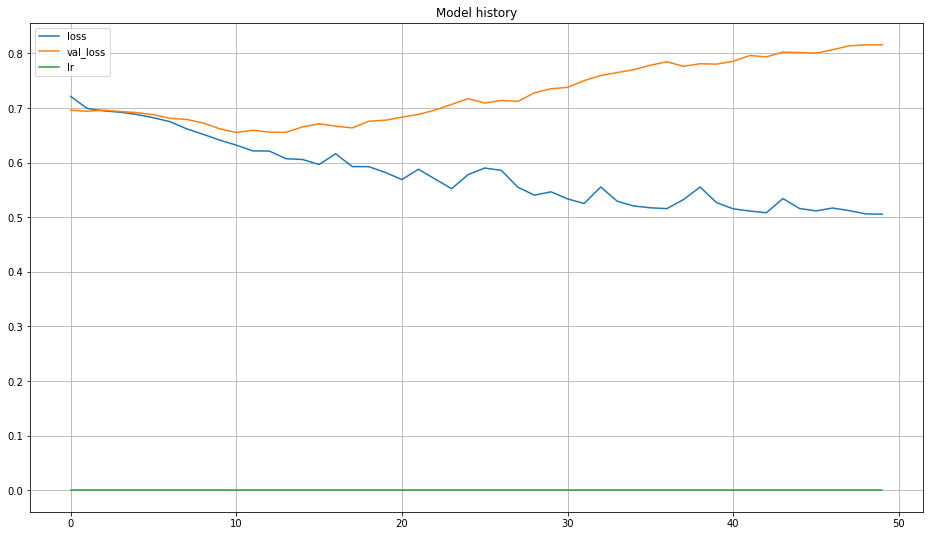

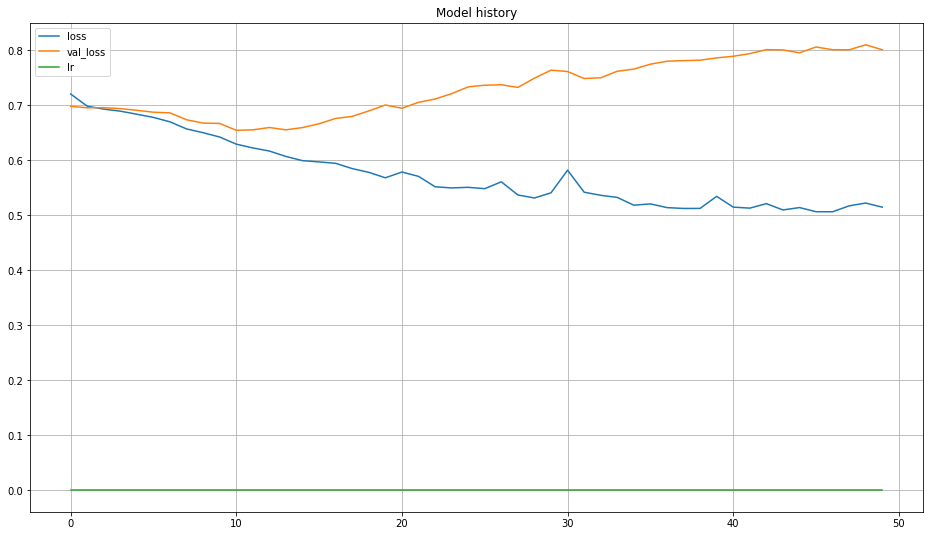

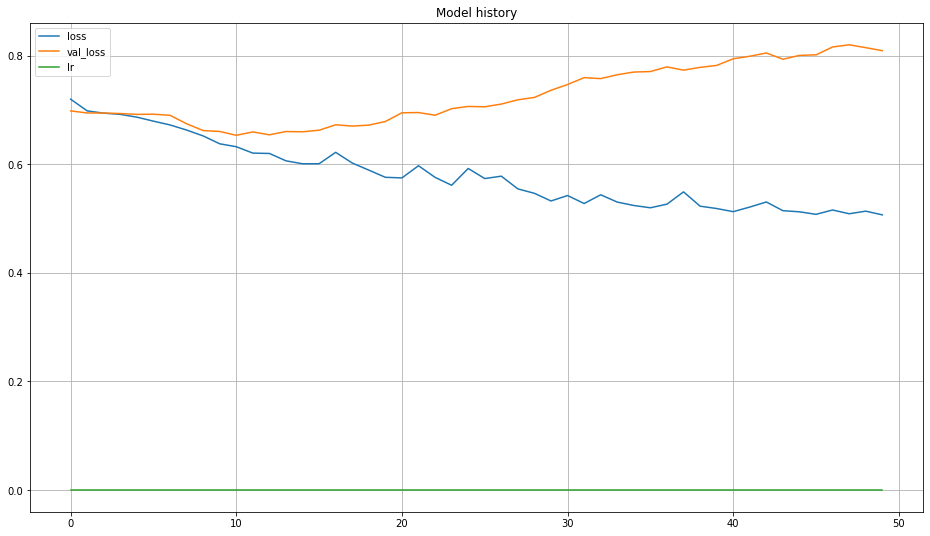

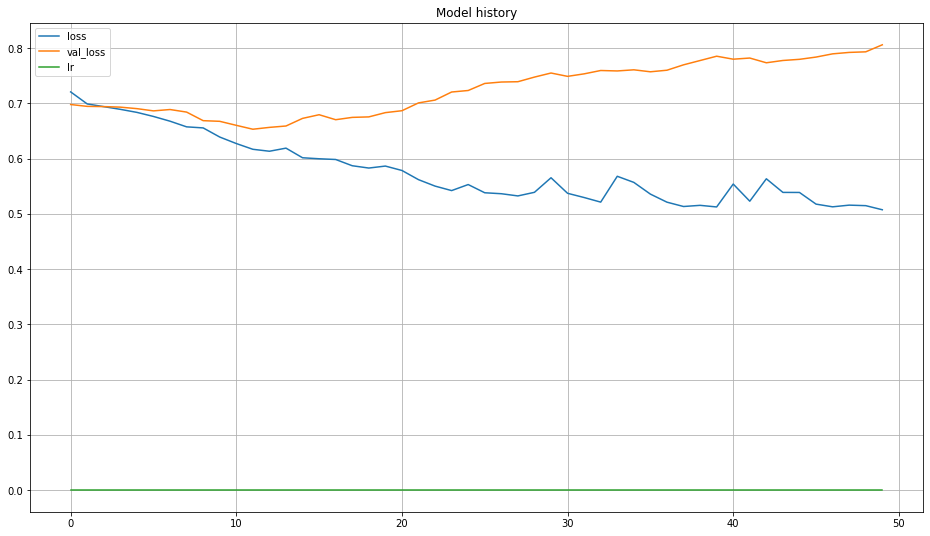

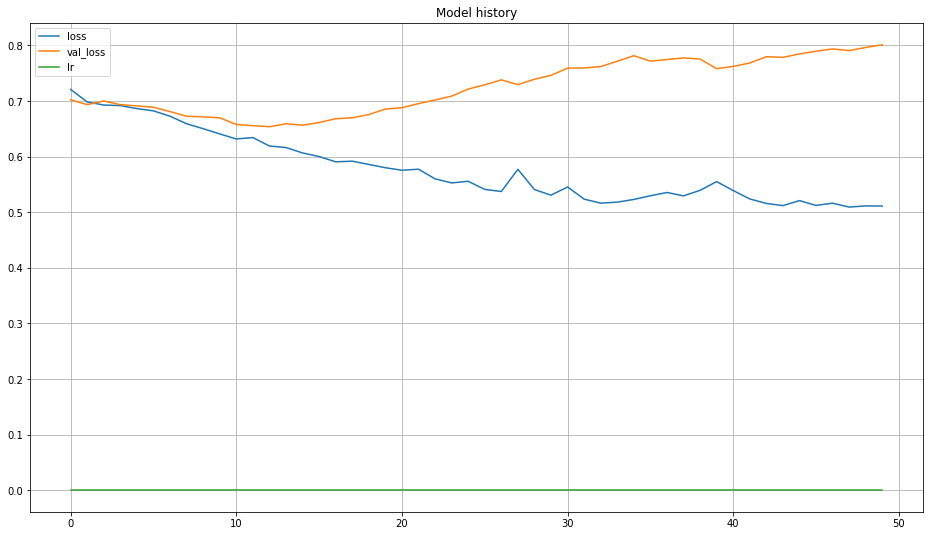

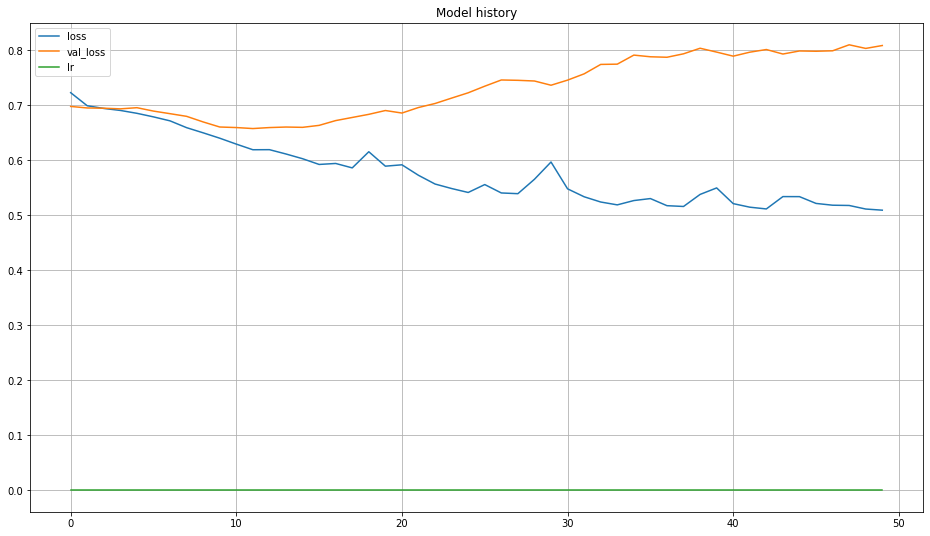

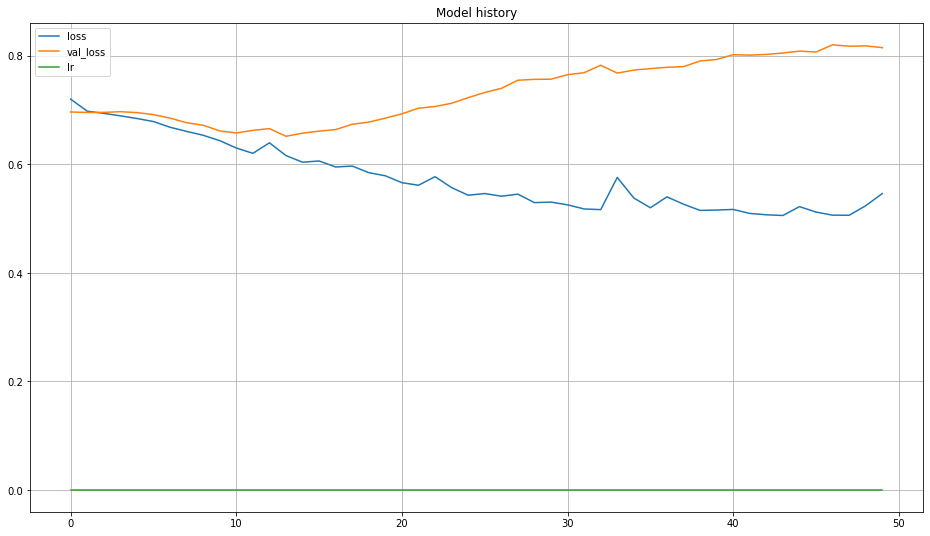

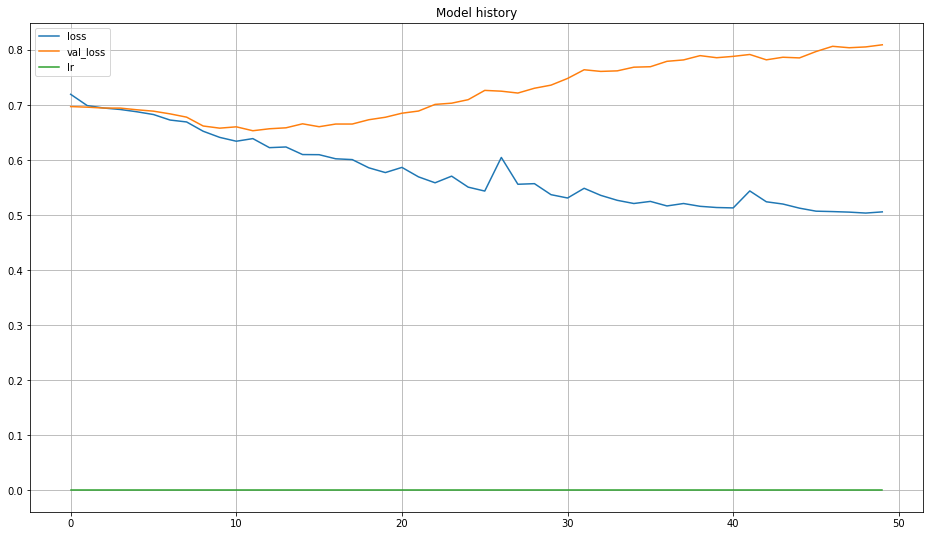

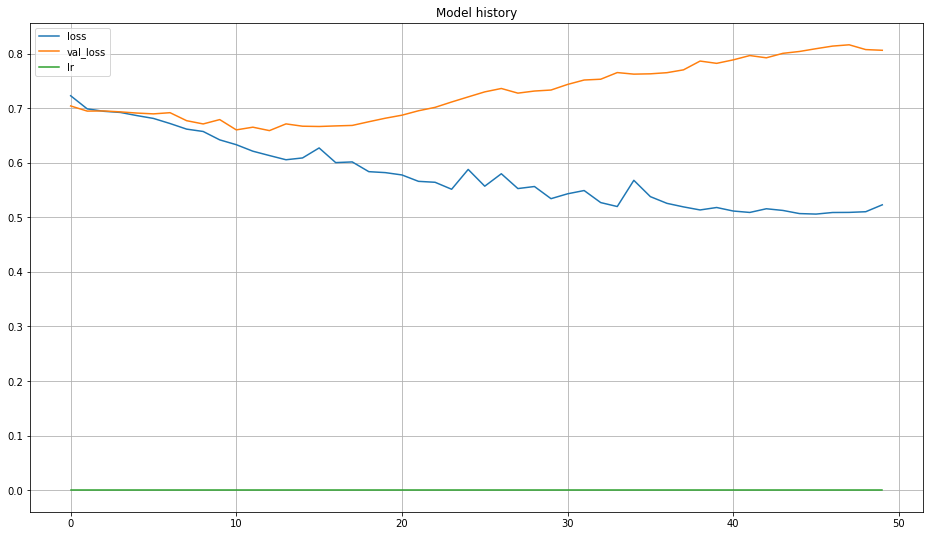

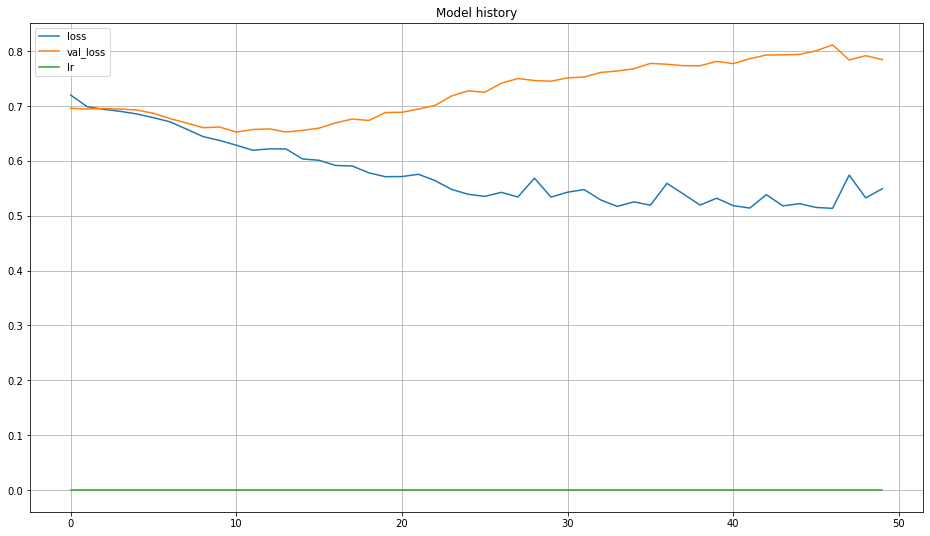

In [20]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score

NUM_RUNS = 10
N_EPOCHS =50
N_ANNOT = 5
K= 2
 
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
AUCSK1 = []


for i in range(NUM_RUNS):
 
    model = build_base_model()

    # add crowds layer on top of the base model
    model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="MW"))


    # instantiate specialized masked loss to handle missing answers
    loss = MaskedMultiCrossEntropy().loss

    # compile model with masked loss and train
    model.compile(optimizer='adam', loss=loss)
    trainHistory =  model.fit(train_batches_MA,validation_data=val_batches_MA, epochs=N_EPOCHS, callbacks = [callback1, callback2], shuffle=True, verbose=2)

    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
        plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()
    
    model.pop() 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_acc = val_acc.numpy()
    print("Validation acc: %.4f" % (float(val_acc),))
    ACC[i] = val_acc
    
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val.numpy(), training=False)
        # tf.print(y_batch_val)
        val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))
        BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
        MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
        AUCSK1.append(roc_auc_score(ook(y_batch_val.numpy()), val_logits[:,:K].numpy().astype('float')))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    #===================================================
    # balanced. Accurcy
    BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))
    AUCSK[i] = np.array(AUCSK1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(AUCSK[i])))
    #MI
    
    MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

In [21]:
ACC

array([0.72162509, 0.71904558, 0.7233448 , 0.70829749, 0.72184008,
       0.71517628, 0.70571798, 0.72678417, 0.71926051, 0.71173686])

In [22]:
AUC

array([0.72189468, 0.71854866, 0.72307914, 0.70861286, 0.72193539,
       0.71461833, 0.70545399, 0.72651994, 0.71906561, 0.71150076])

In [23]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average AUCSK: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUCSK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  71.73
Average std:  0.65
Average AUC:  71.71
Average AUC std:  0.65
Average AUCSK:  79.25999999999999
Average AUCSK std:  0.24
Average Balanced Accuracy:  43.9
Average std:  0.36
Average MI:  10.45
Average std:  0.16999999999999998
Average Normalized MI:  15.160000000000002
Average std:  0.25
Average Ajdusted MI:  15.160000000000002
Average std:  0.25
